In [1]:
# IMPORTS

import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow
import lightkurve as lk
import cv2
import io

from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


2022-07-10 16:05:35.863948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-10 16:05:35.863977: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# PHASE AND BIN FUNCTION

def phase_and_bin(data,period,t0,bin_time):
    data_phased = data.fold(period=period,epoch_time=t0)
    data_binned = data_phased.bin(bin_time)
    return data_binned


In [3]:
# DOWNLOAD (& ADD TO BIG ARRAY)

def download(search):

    lc = search.download()
    #print(type(lc))
    
    if lc is not None:
        #fig, ax = plt.figure()
        #lc.plot(linewidth=0,marker=".")
        #ax.plot(lc)
        #fig.canvas.draw()
        #img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        #img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        #img = cv2.imread(lcplot, 1)
        
        fig,ax = plt.subplots()
        lc.plot(ax=ax)
        io_buf = io.BytesIO()
        fig.savefig(io_buf,format="raw")
        io_buf.seek(0)
        img_arr = np.frombuffer(io_buf.getvalue(),dtype=np.uint8)
        # get image size
        #width = int(fig.bbox.bounds[3])
        #height = int(fig.bbox.bounds[2])
        #print(width)
        #print(height)
        #print(np.shape(img_arr))
        #img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
        io_buf.close()
    
        return img_arr
    

In [4]:
# GET ARRAY OF IMAGE ARRAYS FOR A FILE

def get_lightcurves(filename):

    tbl = pd.read_csv(os.path.abspath(filename),delimiter=",",comment="#")
    
    colnames = tbl.columns.values.tolist()
    if "tid" in colnames:
        TICs = tbl["tid"].astype(str)
    elif "tic_id" in colnames:
        TICs = tbl["tic_id"].astype(str).str[4:]
    else:
        print("No TIC ID column found.")

    print(np.shape(TICs))

    pics = np.array([])

    for x in range(0,32):
        name = TICs[x]
        
        search = lk.search_lightcurve(target=("TIC " + name),author="SPOC")
        pic = download(search)
        print(pic)
        if pic is not None:
            if x == 0:
                pics = np.append(pics,pic)
            else:
                pics = np.vstack([pics,pic])
    
    print("Shape is " + str(np.shape(pics)))
        
    return pics

        

In [5]:
# CREATE TRAIN AND TEST DATASETS

def predictExo(exotrainfile,noexotrainfile,testfile):

    exotraindata = get_lightcurves(exotrainfile) / 255.0
    noexotraindata = get_lightcurves(noexotrainfile) / 255.0
    #testdata = np.array(get_lightcurves(testfile))

    print(np.shape(exotraindata))

    exolabels = np.ones(27)
    noexolabels = np.zeros(27)

    traindata = np.concatenate((exotraindata,noexotraindata)) # issue here - noexotraindata not returning 2d array bc lightcurves return none
    trainlabels = np.concatenate((exolabels,noexolabels))

    traindata = tensorflow.reshape(traindata,[54,1,497664])
    #trainlabels = tensorflow.reshape(trainlabels,[1,54])

    # BUILD CNN MODEL

    #model = keras.Sequential()

    #model.add(keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(1, 497664,1)))
    #model.add(keras.layers.MaxPool2D(2,2))

    #model.add(keras.layers.Conv2D(64,(3,3),activation="relu"))
    #model.add(keras.layers.MaxPool2D(2,2))

    #model.add(keras.layers.Conv2D(128,(3,3),activation="relu"))
    #model.add(keras.layers.MaxPool2D(2,2))

    #model.add(keras.layers.Conv2D(128,(3,3),activation="relu"))
    #model.add(keras.layers.MaxPool2D(2,2))

    #model.add(keras.layers.Flatten())

    #model.add(keras.layers.Dense(512,activation="relu"))

    #model.add(keras.layers.Dense(1,activation="sigmoid"))

    #model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

    # NON-2D CNN MODEL

    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(1,497664)),
        keras.layers.Dense(16,activation="relu"),
        keras.layers.Dense(16,activation="relu"),
        keras.layers.Dense(1,activation="sigmoid")
    ])

    model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

    # TRAIN DATA

    model.fit(
        traindata,
        trainlabels,
        batch_size = 1,
        steps_per_epoch = 250,
        epochs = 10,
    )

    Y = get_lightcurves(testfile) # this returns an array of images!
    
    photos = []

    # reshape image arrays before taking image from them


    tble = pd.read_csv(os.path.abspath(testfile),delimiter=",",comment="#")
    TICid = tble["tic_id"].astype(str)
    
    print(TICid)

    #for z in Y:
    #    z = np.reshape(z,(432,288,-1))
    #    #z = z.transpose((2,0,1))
    #    photo = Image.fromarray((z*255).astype(np.uint8)) # something to do with images are not showing
    #    photos.append(photo)

    #X = np.expand_dims(Y,axis=0)
    X = tensorflow.reshape(Y,[25,1,497664])
    val = model.predict(X).tolist()
    
    for x in range(0,len(val)):
        
        print(x)
        print(val[x])
        #photos[np.where(x)[0][0]].show() # maybe not working?

        if val[x][0] == 1.0:
            print("Exoplanet detected!" + TICid[x])
        elif val[x][0] == 0.0:
            print("No exoplanet detected." + TICid[x])

(32552,)


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


No data found for target "TIC 135596590".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


None


No data found for target "TIC 354489950".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


None
None


No data found for target "TIC 48964101".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


None
None
None
None


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/tmp/ipykernel_1850/1882777312.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
Shape is (25, 497664)
(70,)


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 9 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 18 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 5 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


No data found for target "TIC 276360911".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


None


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 20 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 19 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 26 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 19 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 19 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 7 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 16 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 19 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 11 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 11 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 5 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 14 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


No data found for target "TIC 100504381".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


None


No data found for target "TIC 376168473".
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


None


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 25 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 24 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
Shape is (29, 497664)
(25, 497664)
Epoch 1/10


2022-07-10 16:06:33.431950: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-10 16:06:33.431990: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-10 16:06:33.432003: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sophie-pc): /proc/driver/nvidia/version does not exist
2022-07-10 16:06:33.432245: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


250/250 [==============================] - 5s 21ms/step - loss: 15.1316 - accuracy: 0.6720
Epoch 2/10
250/250 [==============================] - 5s 21ms/step - loss: 5.9656 - accuracy: 0.7920
Epoch 3/10
250/250 [==============================] - 1s 3ms/step - loss: 1.8973 - accuracy: 0.9500
(32199,)


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 12 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 6 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warn

[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]
None
None
None
None
None
None
None


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:341: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
[255 255 255 ... 255 255   0]


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


[255 255 255 ... 255 255   0]
Shape is (25, 497664)
0         TIC 72437047
1         TIC 72437047
2        TIC 230061010
3        TIC 230061010
4        TIC 230061010
             ...      
32194    TIC 189576919
32195    TIC 189576919
32196     TIC 49430557
32197    TIC 375464367
32198    TIC 375464367
Name: tic_id, Length: 32199, dtype: object
0
[1.0]
Exoplanet detected!TIC 72437047
1
[1.0]
Exoplanet detected!TIC 72437047
2
[1.0]
Exoplanet detected!TIC 230061010
3
[1.0]
Exoplanet detected!TIC 230061010
4
[1.0]
Exoplanet detected!TIC 230061010
5
[1.0]
Exoplanet detected!TIC 333225860
6
[1.0]
Exoplanet detected!TIC 333225860
7
[1.0]
Exoplanet detected!TIC 219483057
8
[1.0]
Exoplanet detected!TIC 219483057
9
[1.0]
Exoplanet detected!TIC 219483057
10
[1.0]
Exoplanet detected!TIC 219483057
11
[1.0]
Exoplanet detected!TIC 219483057
12
[1.0]
Exoplanet detected!TIC 219483057
13
[1.0]
Exoplanet detected!TIC 219483057
14
[1.0]
Exoplanet detected!TIC 27533327
15
[1.0]
Exoplanet detected!TIC 275

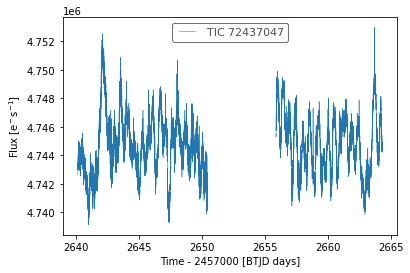

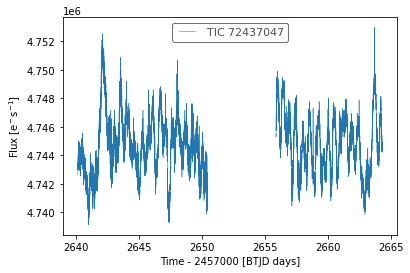

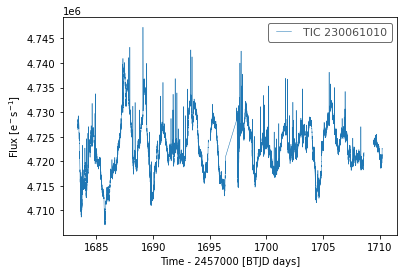

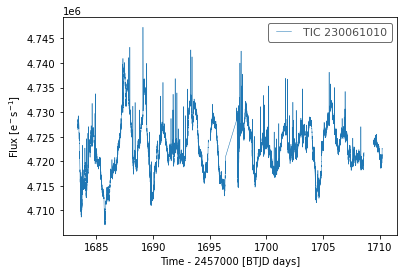

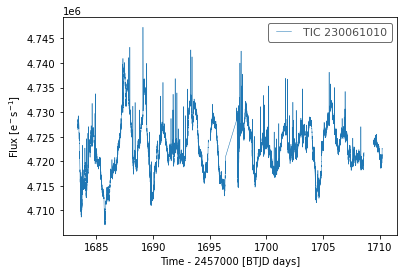

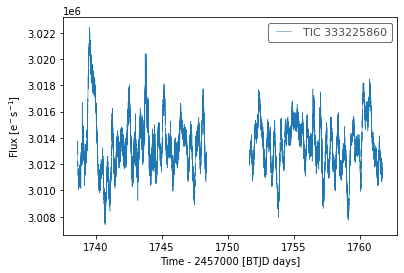

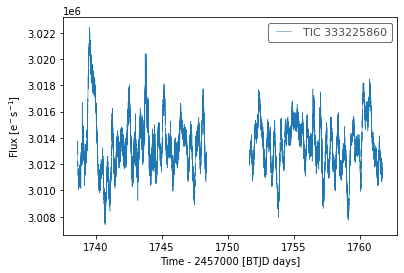

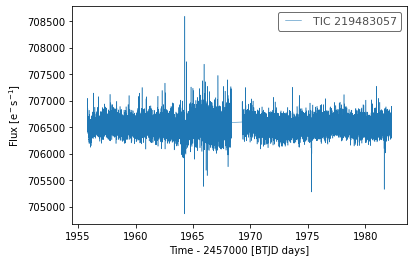

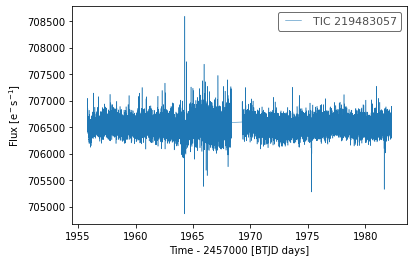

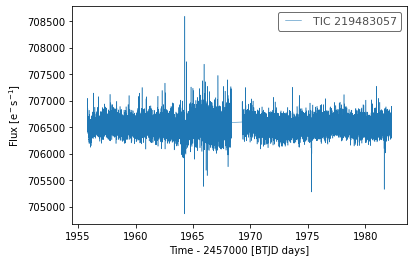

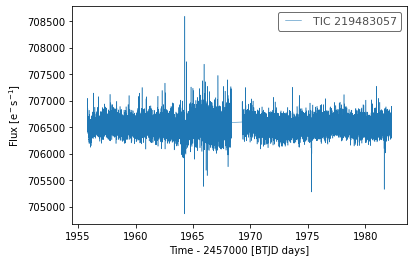

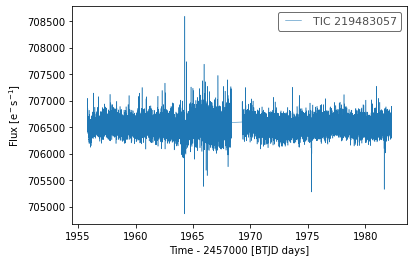

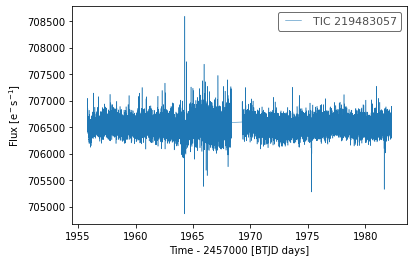

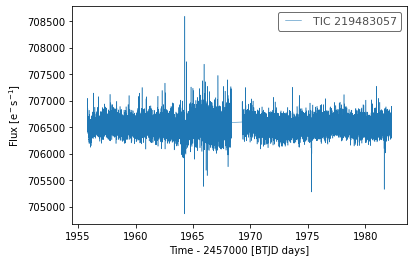

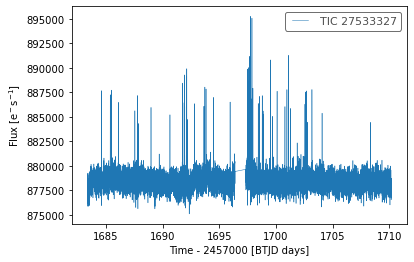

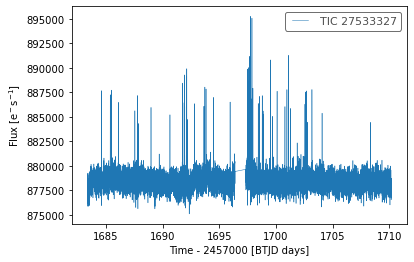

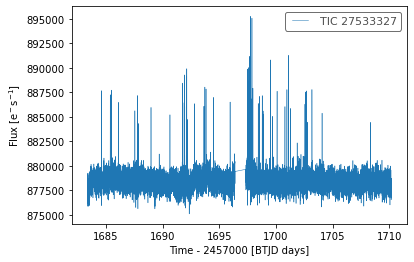

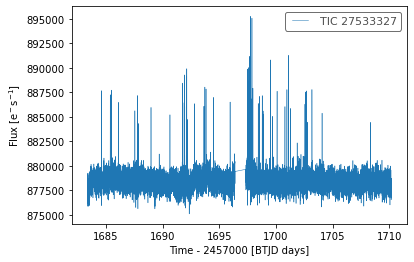

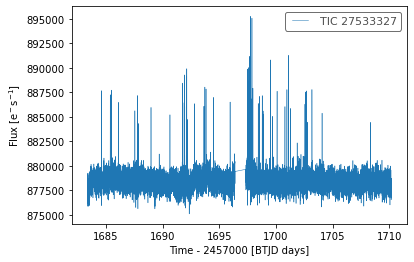

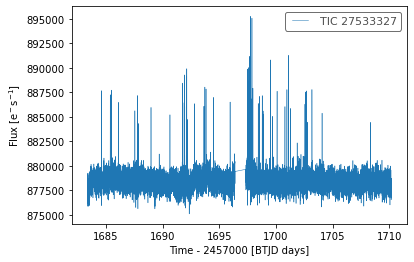

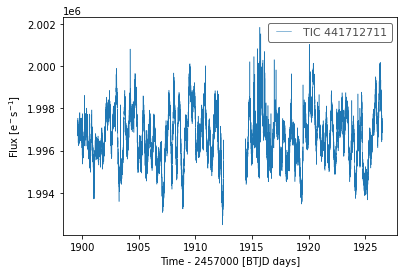

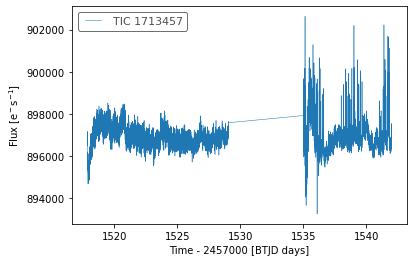

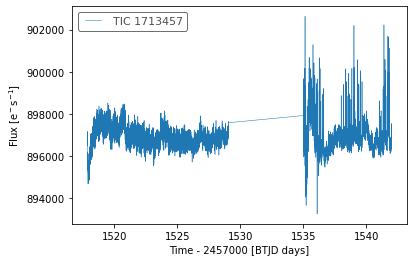

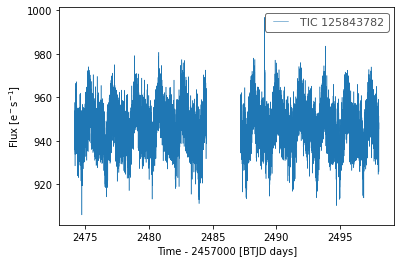

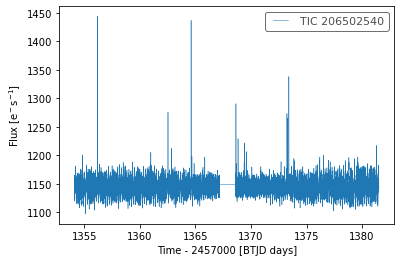

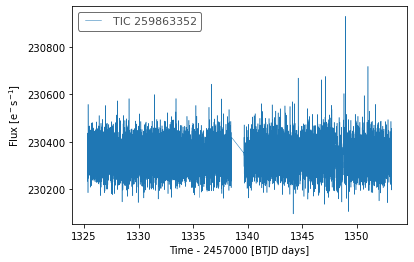

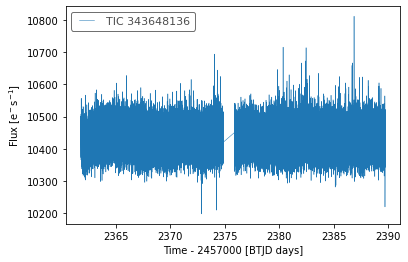

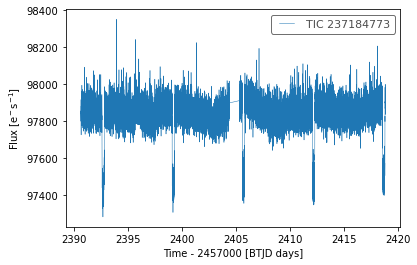

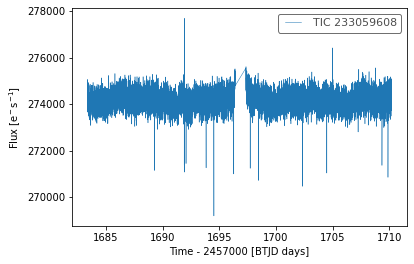

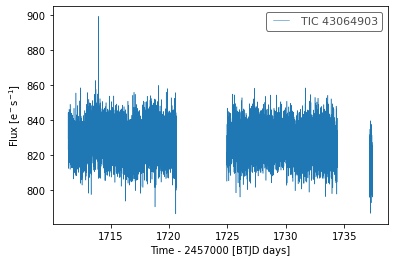

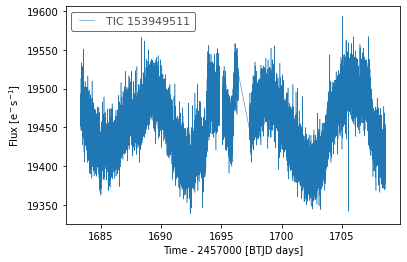

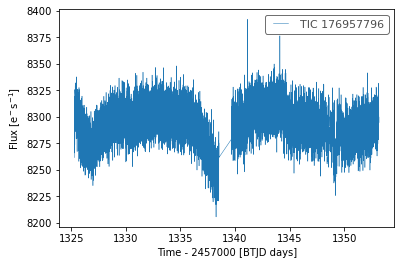

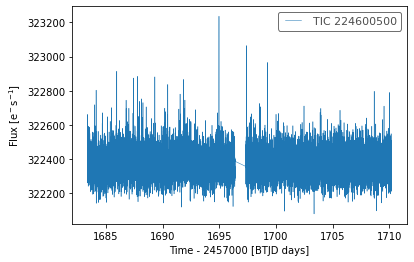

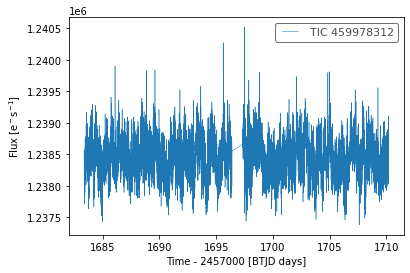

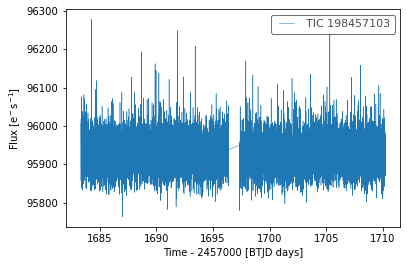

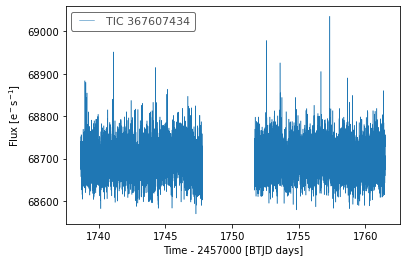

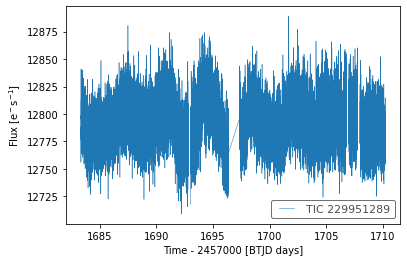

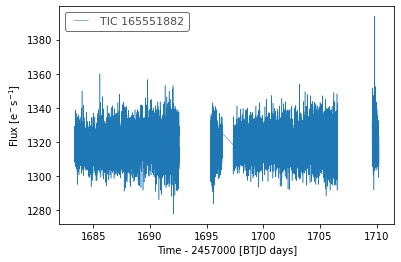

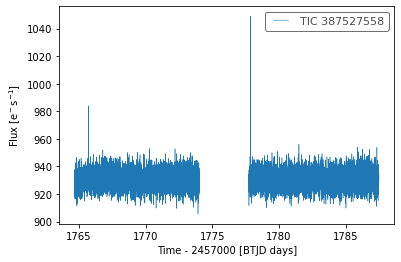

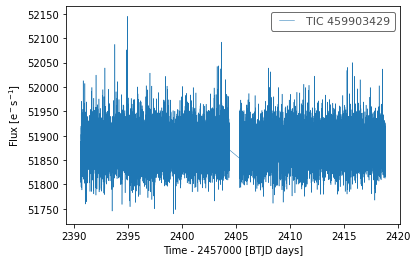

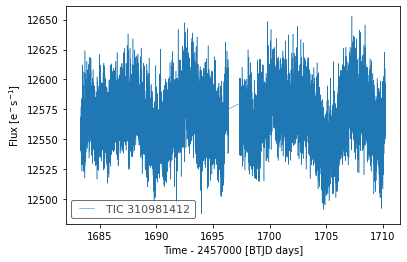

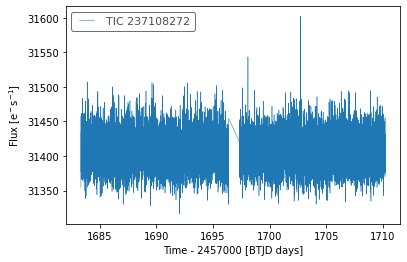

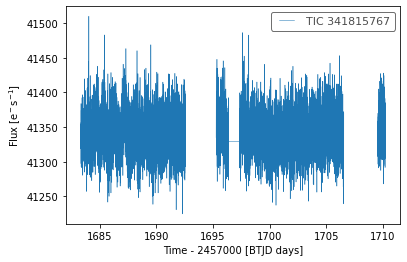

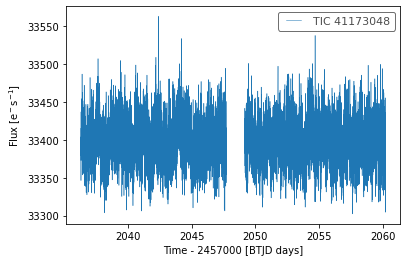

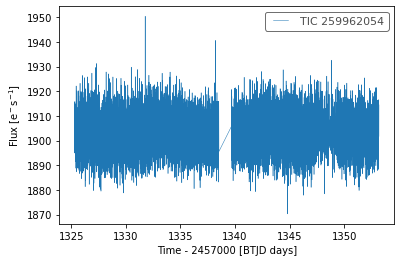

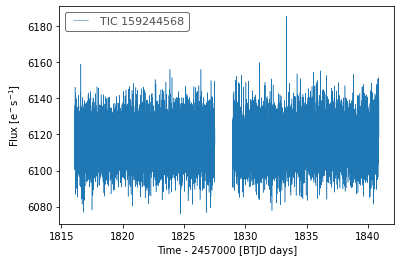

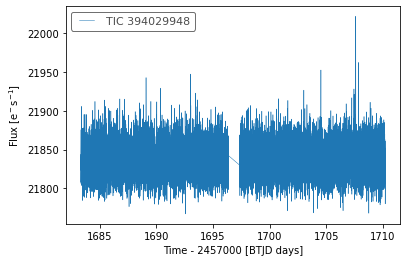

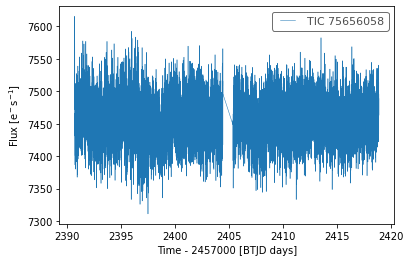

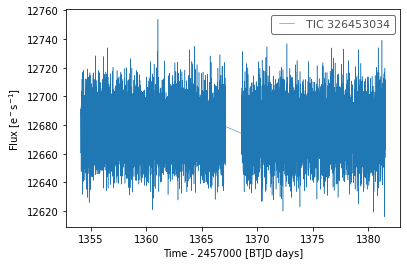

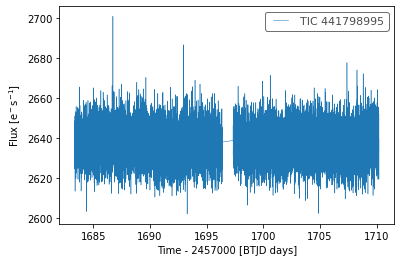

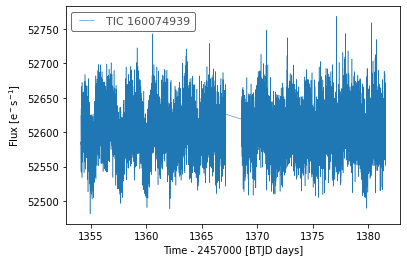

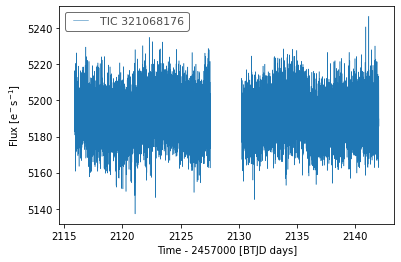

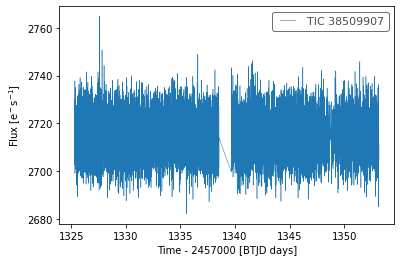

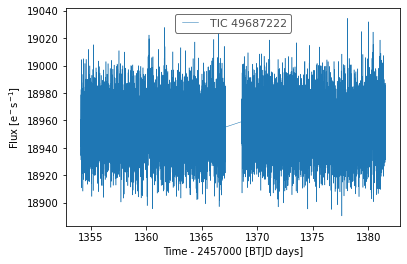

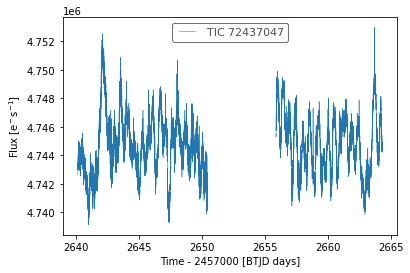

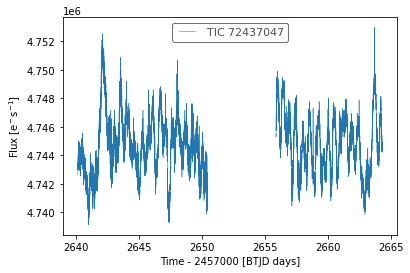

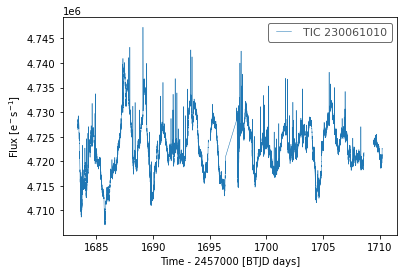

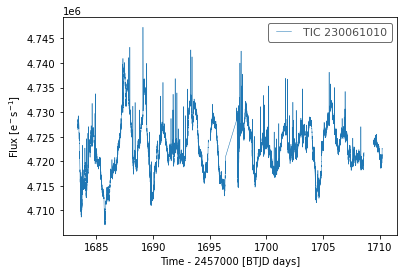

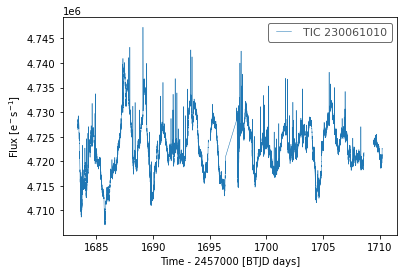

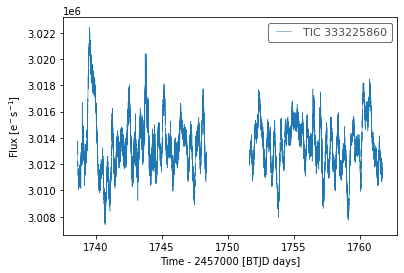

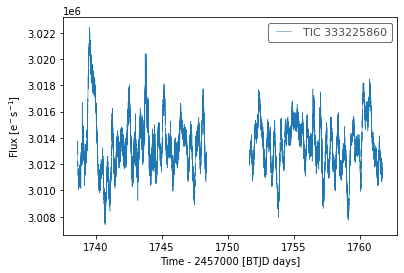

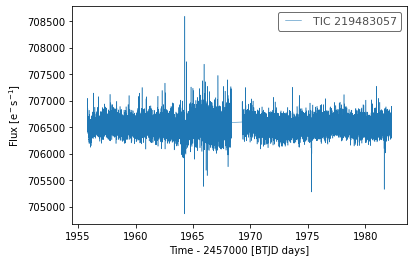

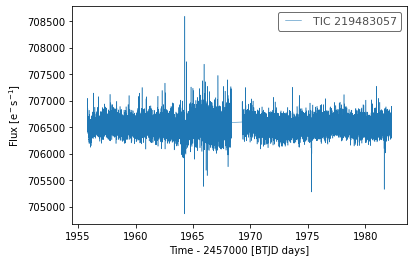

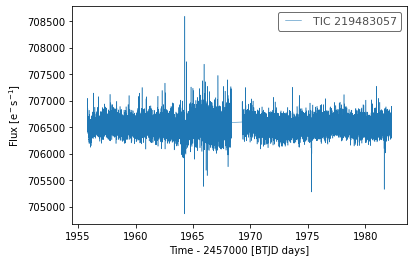

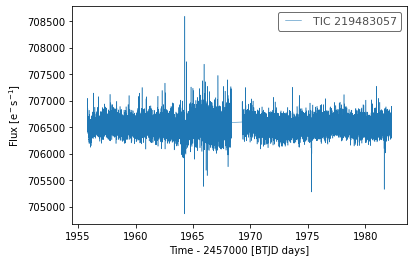

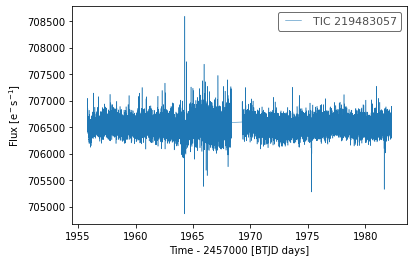

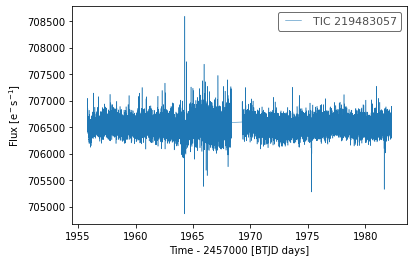

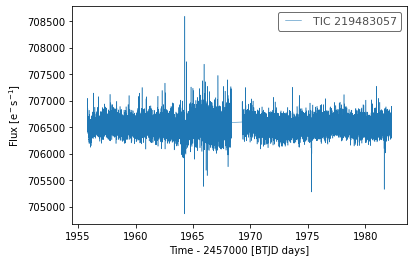

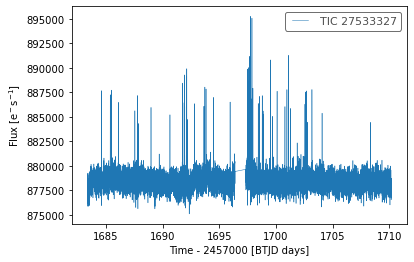

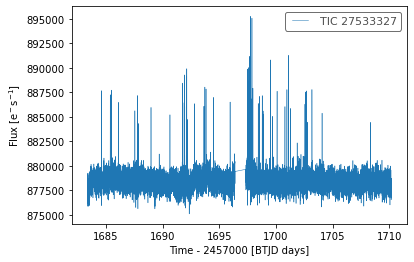

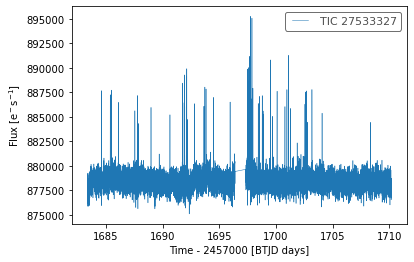

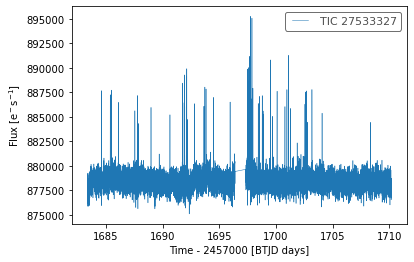

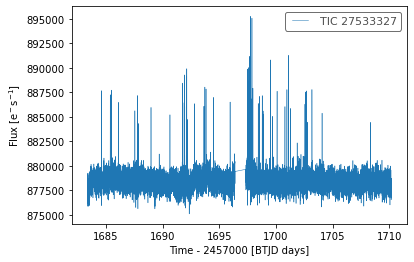

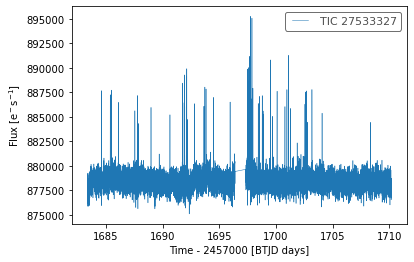

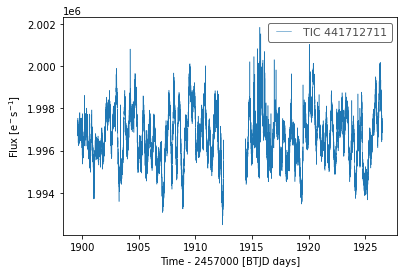

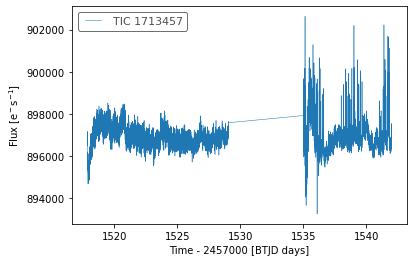

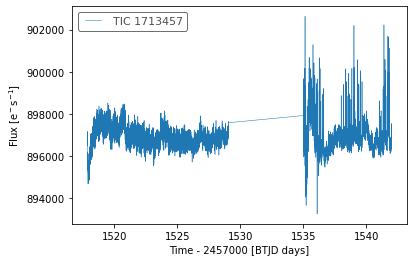

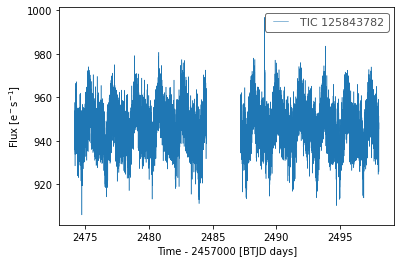

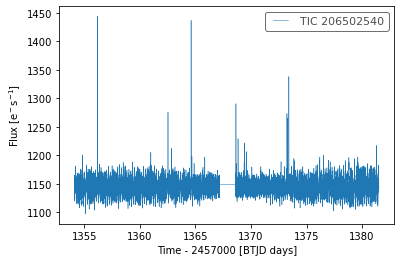

In [6]:
predictExo("PS_2022.06.27_08.12.38.csv","TOI_2022.06.29_08.07.35.csv","PS_2022.07.04_02.32.20.csv")